In [12]:
import sys
path2cpp_pkg = "/Users/mariusmahiout/Documents/repos/ising_core/build"
sys.path.append(path2cpp_pkg)
import ising

import os
os.chdir("/Users/mariusmahiout/Documents/repos/ising_core/python")

import src.misc_plotting as plotting
import src.utils as utils
import src.model_eval as eval
import src.isingfitter as fitter

import numpy as np
import matplotlib.pyplot as plt
import time

In [22]:
num_units = 5
num_sims = 15000
num_burn = 1000
lr = 0.01
max_steps = 1000

In [23]:
##############
# SIMULATION #
##############

# setting up model
beta = 1.3
h = np.random.uniform(-.3 * beta, .3 * beta, num_units)
J = np.random.normal(0,  beta / np.sqrt(num_units), (num_units, num_units))
for i in range(num_units):
    J[i, i] = 0
    for j in range(i+1, num_units):
        J[j, i] = J[i, j]

true_model = ising.EqModel(J, h)

# simulating
t0 = time.time()

true_sim = true_model.simulate(num_sims, num_burn)

t1 = time.time()
dt = t1 - t0
print("Simulation took {:.2f} seconds.".format(dt))

Simulation took 0.02 seconds.


In [24]:
#############
# INFERENCE #
#############

# setting up model
h_init = np.random.uniform(-1.5, 1.5, num_units)
J_init = np.random.normal(0,  1,  (num_units, num_units))
J_init = (J_init.T + J_init) * np.sqrt(2) / 2
np.fill_diagonal(J_init, 0)

ml_model = ising.EqModel(J_init, h_init)

ml_fitter = fitter.EqFitter(ml_model)
ml_fitter.TAP(true_sim)

# inference
t0 = time.time()

ml_fitter.maximize_likelihood(
    sample=true_sim, 
    max_steps=max_steps, 
    learning_rate=lr, 
    num_sims=num_sims, 
    num_burn=num_burn,
    calc_llh=True
)

t1 = time.time()
dt = t1 - t0
print("Inference took {:.2f} seconds.".format(dt))

Inference took 21.62 seconds.


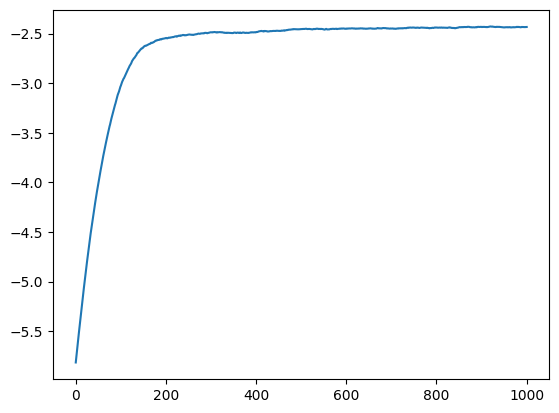

In [25]:
plt.plot(ml_fitter.llhs)

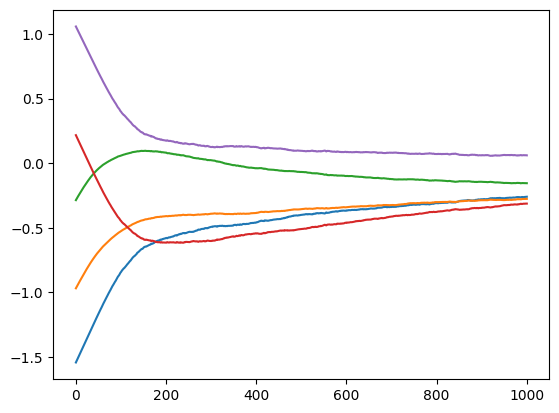

In [31]:
plt.plot(ml_fitter.fields_history)

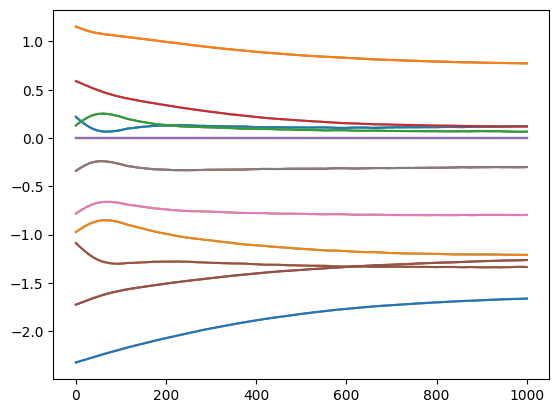

In [34]:
plt.plot([J.flatten() for J in ml_fitter.couplings_history])

In [26]:
nmf_model = ising.EqModel(J_init, h_init)
tap_model = ising.EqModel(J_init, h_init)

In [27]:
nmf_fitter = fitter.EqFitter(nmf_model)
nmf_fitter.naive_mean_field(true_sim)

tap_fitter = fitter.EqFitter(tap_model)
tap_fitter.TAP(true_sim)

In [28]:
##############
# SIMULATION #
##############

ml_sim = ml_model.simulate(num_sims, num_burn)
nmf_sim = nmf_model.simulate(num_sims, num_burn)
tap_sim = tap_model.simulate(num_sims, num_burn)



In [29]:
def get_metadata(
    num_units,
    is_empirical_analysis,
    eq_inv_methods=[],
    neq_inv_methods=[],
    **kwargs
):
    metadata = {}
    metadata["num_units"] = num_units

    if is_empirical_analysis:
        bin_width = kwargs['bin_width']
        num_bins = kwargs['num_bins']
        metadata['bin_width'] = bin_width
    else:
        num_sims = kwargs['num_sims']
        num_burn = kwargs.get('num_burn', 1000)
        true_fields = kwargs['true_fields']
        true_couplings = kwargs['true_couplings']
        metadata["true_model"] = {
            'true_fields' : true_fields,
            'true_couplings' : true_couplings,
            'num_sims' : num_sims,
            'num_burn' : num_burn,
        }

    if (eq_inv_methods != []) or (neq_inv_methods != []):
        metadata["inverse_methods"] = {
            'EQ' : eq_inv_methods,
            'NEQ' : neq_inv_methods,
        }
        if ('ML' in eq_inv_methods) or ('ML' in neq_inv_methods):
            # each can be dict if multiple ML models with different hyperparams
            num_steps = kwargs['num_steps']
            learning_rate = kwargs['learning_rate']
            is_converged = kwargs['is_converged']
            metadata['maximum_likelihood'] = {
                'num_steps' : num_steps,
                'learning_rate' : learning_rate,
                'is_converged' : is_converged,
            }
        if ('ML' in eq_inv_methods):
            num_sims_ml = kwargs['num_sims_ml']
            num_burn_ml = kwargs.get('num_burn_ml', 1000)
            metadata['maximum_likelihood']['num_sims'] = num_sims_ml
            metadata['maximum_likelihood']['num_burn'] = num_burn_ml
    return metadata

In [30]:
labels = ["ML", "nMF", "TAP"]
metadata = get_metadata(
    num_units=num_units,
    is_empirical_analysis=False,
    eq_inv_methods=labels,
    num_sims=num_sims,
    true_fields="uniform(-.3 * beta, .3 * beta); beta=1.3",
    true_couplings="normal(0,  beta / sqrt(num_units)); symmetric, beta=1.3",
    num_steps=max_steps,
    learning_rate=lr,
    is_converged=None,
    num_sims_ml=num_sims,
    num_burn_ml=num_burn,
)


def get_analysis_path(analysis_name, num_units, bin_width):
    analysis_path = '../analyses/'
    dir_name = f'n{num_units}b{bin_width}{analysis_name}'
    analysis_path += f'./{dir_name}/'
    return analysis_path


analysis_name = "test"
bin_width = 0
analysis_path = get_analysis_path(analysis_name, num_units, bin_width)

layout_spec = {
    ("fields", "scatter"): (1, 1),
    ("means", "scatter"): (1, 2),
    ("couplings", "scatter"): (2, 1),
    ("pcorrs", "scatter"): (2, 2),
}

ising_eval = eval.IsingEval(
    analysis_path=analysis_path, 
    metadata=metadata, 
    true_model=true_model, 
    est_models=[ml_model, nmf_model, tap_model],
    true_sample=true_sim,
    est_samples=[ml_sim, nmf_sim, tap_sim], 
    labels=labels,
    layout_spec=layout_spec
)
ising_eval.generate_plots()

    'data': [{'legendgroup': 'ML',
              'marker': {'color': 'blue', 'si…

# Next steps

0. Seems LLH calculation is working (the LLH is increasing...), do some more plotting, and **implement convergence criterion**
1. Try to figure out why the pseudolikelihood method is less performant than the exact LLH maximization procedure...
2. Implement the NEQ stuff
3. Testing the sampler (this should be much quicker now!)
4. Reproduce some of the figures from Nguyen et al. (and/or from one of Yasser's papers)


## C++ code
1. potential modifications to pseudolikelihood method
2. NEQ stuff

## Python code
1. Include code for plotting history and all that
2. NEQ stuff


When all of the above is finished, we're almost done, the remainder incldues:
- Including the code for dealing with neural recordings (I think this should be easy, and will happen in python)
- Investigating the observables for the neural recordings
- Fitting some good models to the neural recordings.
    - Here, I'm thinking I'll use a combined approach, somehting like TAP -> PL -> ML (EQ), and TAP -> ML (NEQ)
    - We can also do a few runs of fitting with all the methods seperately, but this should not be the main focus
    - Ideally, we can extract some insight into the neural data from the models, once they've been fitted

Note: Consider paying for compute? Need to get up to speed on how to use this, but I don't think this should be that hard...


## Once project is finalized
- Make public on GitHub (exclude the data)
- Get in touch with Yasser (Also, congratulate him on his new position and ask how he's doing)
- Add it to projects on website
- Perhaps make a blog post discussing your decision to revize the project
    - Got hurried at the end, and although I recieved top marks, was not happy with the final product (figures, code, etc.).
    - At the time, I was still a novice programmer and a novice in ML, and so a lot of the efforts were spent on learning the basics of ML and software development
    - Conclusion of the above: despite recieving an A, there was ample room for improvement.
    - Wanted to learn C++ (with high performance computing and robotics applications in mind), and so thought revizing a previous software project would be a good way to get my feet wet. In particular, my masters project involved some heavy computations, and so was a good candidate for this
    - Note: at this point, should also discuss some of the performance gains you saw
- Consider doing a mini-project related to RBMs, with an associated blog post(s) introducing RBMS, and one discussing the project

Note: could also add the IRL project to the website (don't have to make a big deal out of this --> should only take an afternoon)